In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.models import load_model
import numpy as np
from collections import Counter
from gensim.models import KeyedVectors
import time
import tqdm
import keras_contrib
from keras.models import Model
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from keras import backend as K
from numba import jit
from triplet_loss import batch_hard_triplet_loss
from transformers import BertTokenizer, TFBertModel
import json
import random
import copy
import cv2
import numpy as np
from nltk.tokenize import RegexpTokenizer
from keras.preprocessing import sequence
from collections import Counter
from numba import cuda
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
def get_test(json_path, dataset_path, word_model, tokenizer, time_step):
    ''' Read from caption_test.json
        Args:
            json_path:  .../.../caption_test.json
            dataset_path:  .../.../CUHK_PEDES
        Returns:
            ndarray
            imgs: (2000,384,128,3)
            ids: (2000,1)
            caps: (2000,50,50)
    '''
    ids = []
    imgs = []
    caps = []
    orig_caps = []

    js_data = json.load(open(json_path))
    for data in js_data:
        if len(ids) == 1000:
            break
        image = cv2.imread(dataset_path + "/imgs/" + data["file_path"])
        image = cv2.resize(image, (128, 384))
        image = image[:,:,::-1] #BGR to RGB

        ids.append(data["id"])
        imgs.append(image)

        caption = data['captions']
        orig_caps.append(caption)
        caps.append(tokenizer.encode(caption))

    input_ids = sequence.pad_sequences(caps, maxlen=time_step, dtype='int', padding='post', truncating='post', value=0)
    input_ids = tf.constant(input_ids)
    attention_mask = np.where(input_ids != 0, 1, 0)
    attention_mask = tf.constant(attention_mask)
    outputs = word_model(input_ids, attention_mask=attention_mask)
    caps = np.array(outputs[0])
    
    return np.array(ids),np.array(imgs),np.array(caps),np.array(orig_caps)

@jit(nopython=True)
def compute_score(mat, ids):
    rank1 = 0
    rank5 = 0
    rank10 = 0
    rank20 = 0
    rank1_l = []
    rank5_l = []
    rank10_l = []
    notfound_l = []

    idx = 0 # Keep track of true id
    print()
    print("Computing RankX")
    for ii in range(len(mat)):
        idx_score = mat[ii]
        res_ids = ids[idx_score]
        #print(res_ids[:20])

        match = False
        for i, res_id in enumerate(res_ids):
            if res_id == ids[idx]:
                match = True
            if i == 0 and match:
                rank1 += 1
                rank1_l.append(ii)
            if i == 9 and match:	# we have replicated image, so here i is 9
                rank5 += 1
                rank5_l.append(ii)
            if i== 19 and match:
                rank10 += 1
                rank10_l.append(ii)
            if i == 39:
                if match > 0:
                    rank20 += 1
                else:
                    notfound_l.append(ii)
                break
        idx += 1

    print("Rank1: ")
    print(rank1/(idx+1))
    print("Rank5: ")
    print(rank5/(idx+1))
    print("Rank10: ")
    print(rank10/(idx+1))
    print("Rank20: ")
    print(rank20/(idx+1))

    return rank1_l, rank5_l, rank10_l, notfound_l

def get_models(model):
    #print(model.summary())

    print("Image Weights: ")
    img_input = model.layers[0].input
    img_output = model.layers[-3].output
    img_model = Model(img_input, img_output)

    print("Caption Weights: ")
    cap_input = model.layers[-6].input
    cap_output = model.layers[-2].output
    cap_model = Model(cap_input, cap_output)
    return img_model, cap_model

def triplet_loss(y_true, y_pred):

    label = K.flatten(y_true[:,0,0])

    loss = batch_hard_triplet_loss(label, y_pred[:,1], y_pred[:,0], 0.2)
    return loss

In [3]:
TIME_STEP = 100
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
word_model = TFBertModel.from_pretrained('bert-base-uncased')
ids, imgs, caps, orig_caps = get_test("caption_test.json", "../datasets/CUHK-PEDES", word_model, tokenizer, TIME_STEP)

model = load_model("../best_model.h5", custom_objects={'tf': tf, 'triplet_loss': triplet_loss, 'K': K, 'InstanceNormalization':keras_contrib.layers.InstanceNormalization})

img_model, cap_model = get_models(model)	# get img path and cap path and resemble to new models

print("data and model loaded")

print("Computing Distance")
img_out = img_model.predict(imgs)
cap_out = cap_model.predict(caps)
mat = cosine_similarity(cap_out, img_out) #compute cosine, output shape(6248*6248) --> (cap, img)
sim_score = mat
mat = np.array([np.argsort(score)[::-1] for score in mat])
mat = mat.astype(np.int)
ids = ids.astype(np.int)
print("Matrix Ready")

rank1, rank5, rank10, notfound = compute_score(mat, ids)

Image Weights: 
Caption Weights: 
data and model loaded
Computing Distance
Matrix Ready

Computing RankX
Rank1: 
0.48451548451548454
Rank5: 
0.7712287712287712
Rank10: 
0.8501498501498501
Rank20: 
0.9200799200799201


In [4]:
cuda.select_device(0)
cuda.close()

In [35]:
rank10 = list(set(rank10) - set(rank5))
rank5 = list(set(rank5) - set(rank1))

for i in [rank1, rank5, rank10, notfound]:
    print(len(i))

485
287
79
79


11
A woman looks down while descending and carrying both a red handbag and red-and-white plastic bag in one hand. She also has a small yellow handbag at her hip with the chain strap across her body while dressed in a black scarf over an Aline pink mini-dress and black sandals with thick white soles.


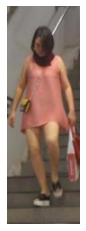

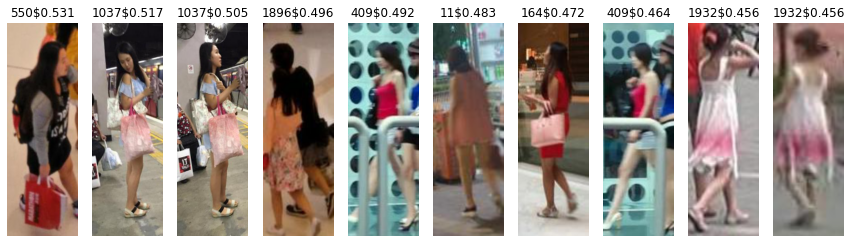

16
A man wearing a blue shirt, a pair of black pants and a brown bag in his left hand.


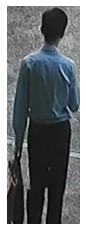

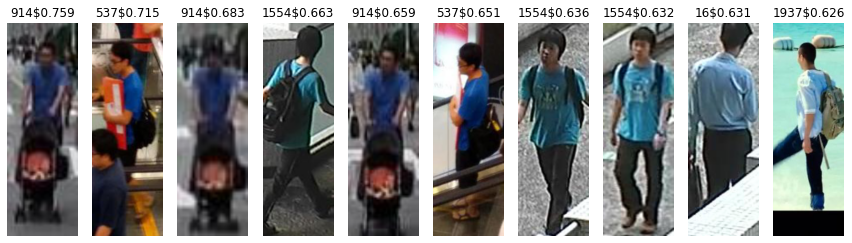

18
He has short black hair and is wearing a black shirt. He is also wearing white pants.


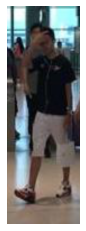

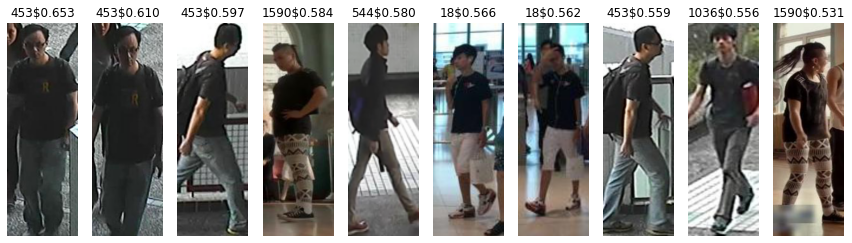

1017
The man is wearing a grey short-sleeved shirt and blue jeans. His hair is cut short.


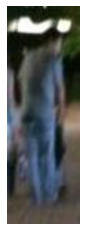

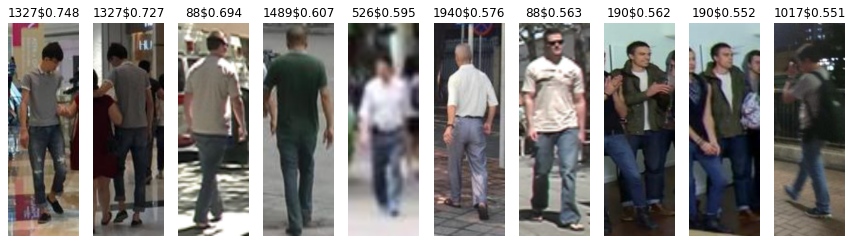

1031
A woman wears eyeglasses, a black, shirtsleeve top and black sandals and also carries a shoulder bag on her right side that swings in back of her.


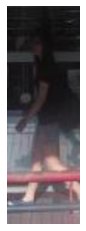

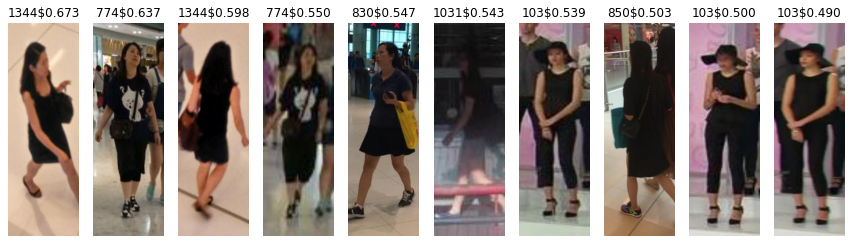

27
She is wearing black pants and a white hooded sweatshirt with a black hood. She is also wearing a yellow rucksack.


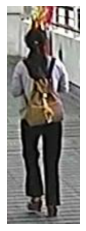

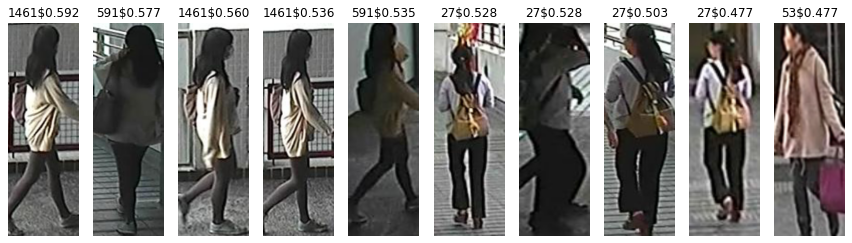

47
The person has dark hair and is wearing a light blue shirt and dark grey shorts.


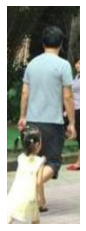

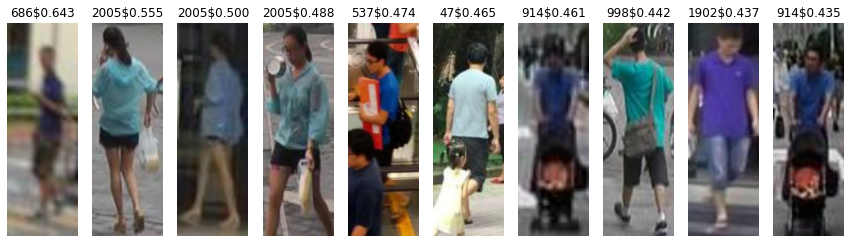

47
Man is wearing a teal coloured t shirt. He is also wearing dark shorts and sandals


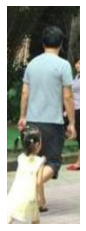

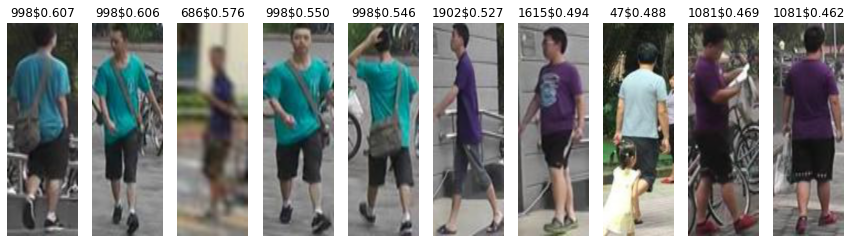

1036
A man wearing a Gray shirt, a pair of Gray pants and a pair of Gray and white shoes.


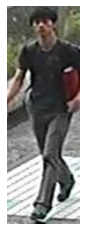

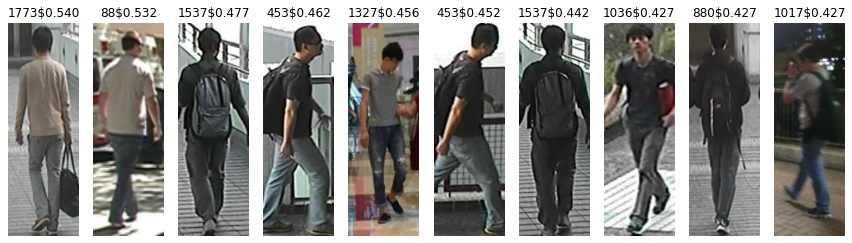

1041
He is wearing tan pants, a black shirt, and a long sleeved brown shirt opened on top.


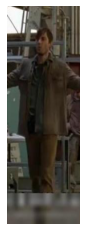

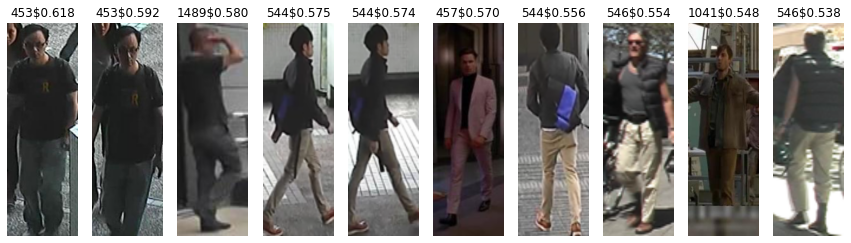

1082
A man wearing a red shirt, a pair of blue jeans, a red hat and pair of white shoes.


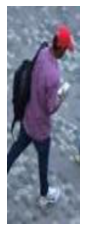

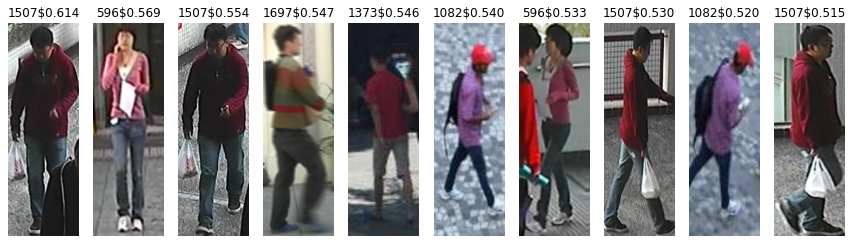

164
A woman wearing a tight, red dress a pair of silver high heeled dress shoes and a pink bag over her left arm.


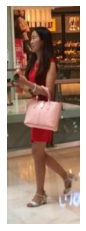

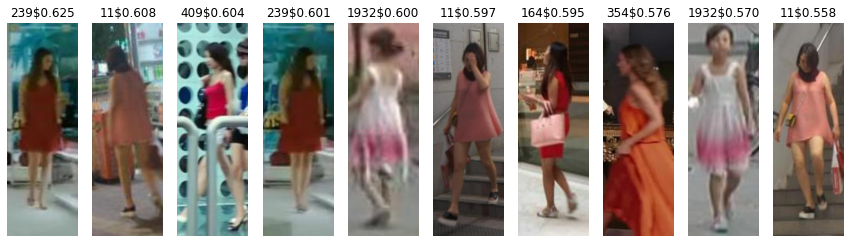

164
A long haired woman wearing a mid length red sleeveless dress and carrying a pink large tote is walking down a street.


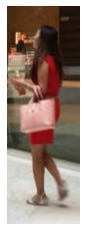

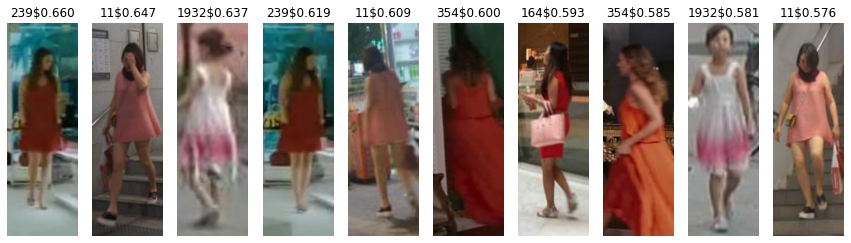

190
The man is wearing a green jacket with a white shirt underneath. He is also wearing blue jeans.


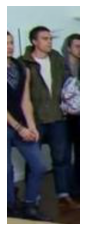

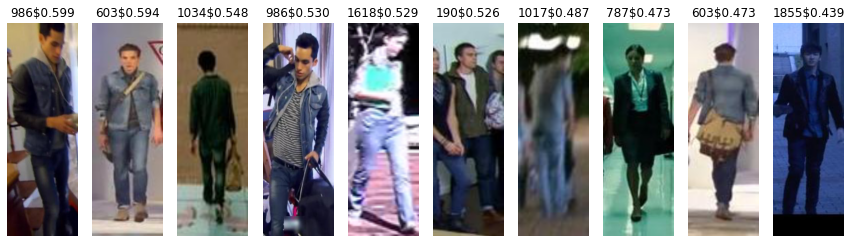

203
The man appears to be jogging and is wearing a white shirt with black pants.


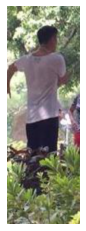

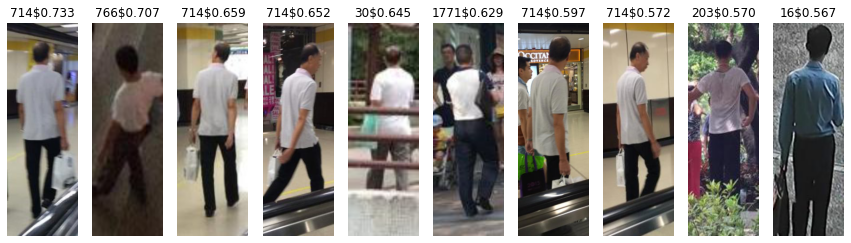

203
The man is wearing a white shirt and black pants. He has short black hair and is facing away from the camera.


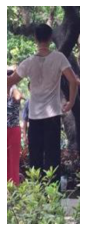

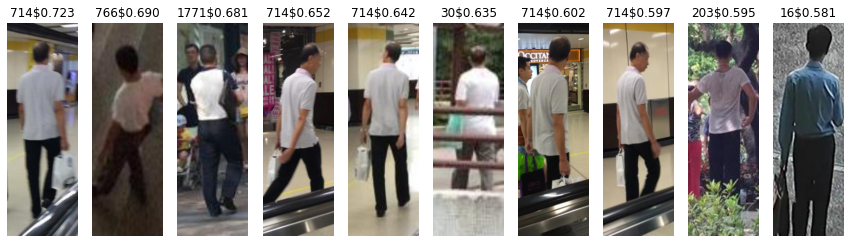

203
This person has on a necklace, a white t shirt, black pants. We see him from behind. His left arm is visible to the elbow and his right arm is bent


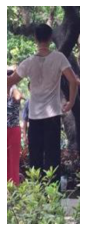

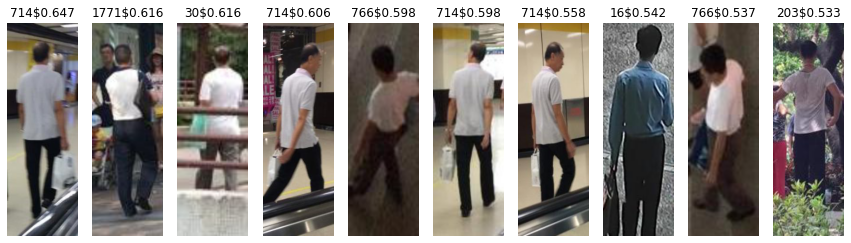

1167
A man with short black hair and glasses wearing a white shirt with black sleeves and light blue shorts with sandals.


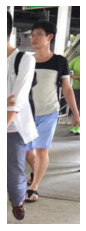

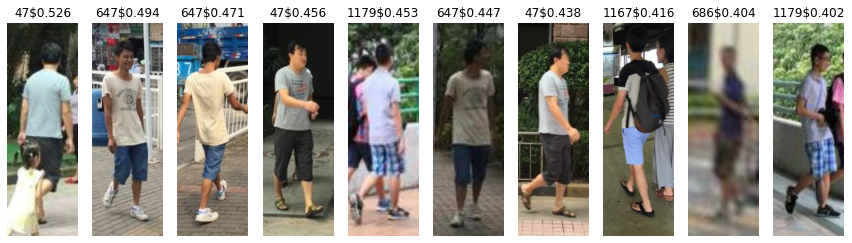

1178
The lady is wearing a long sleeved Gray top with a short blue jean skirt. She has on white shoes and dark sunglasses.


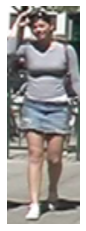

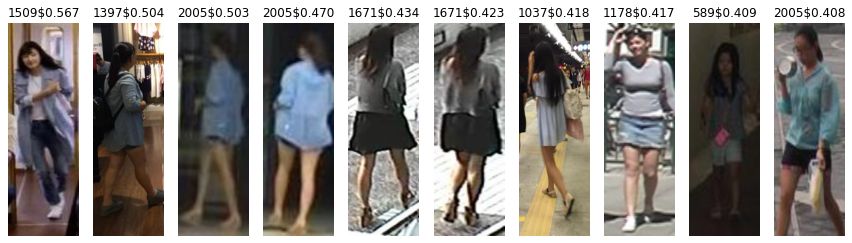

1178
A woman with brown hair pulled back is standing with a black bag on her left shoulder. She is wearing a Gray sweater and Gray skirt with brown shoes.


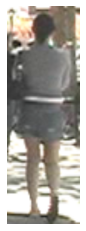

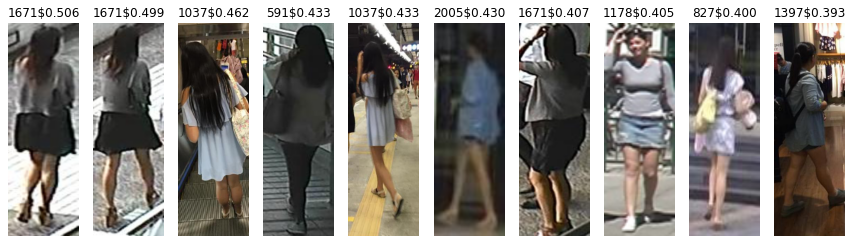

In [49]:
print_imgs = rank10[:20]
columns = 10
rows = 1

for kk in print_imgs:
    plt.axis('off')
    plt.imshow(imgs[kk])
    print(ids[kk])
    print(orig_caps[kk])
    temp = mat[kk]
    temp = temp[:columns*rows*2]
    temp_imgs = imgs[temp]
    temp_sims = sim_score[kk][temp]
    temp_ids = ids[temp]
    fig = plt.figure(figsize=(15, 15))
    
    count = 0
    for i in range(1, columns*rows +1):
        sub_temp = fig.add_subplot(rows, columns, i)
        sub_temp.title.set_text(str(temp_ids[(i-1)*2]) + '$' + str(temp_sims[(i-1)*2])[:5])
        plt.imshow(temp_imgs[(i-1)*2])
        plt.axis('off')
        #plt.tight_layout(pad=9.0)
    plt.show()